In [1]:
#!/usr/bin/env python3
import sys
import smach
import rospy
import cv2 as cv
import numpy as np
from std_srvs.srv import Empty
from tmc_msgs.msg import Voice
from geometry_msgs.msg import TransformStamped
import moveit_commander
import moveit_msgs.msg
import tf2_ros as tf2
from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
from utils_takeshi import *
from grasp_utils import *

In [2]:
    global head, whole_body, arm, tfbuff, lis, broad, tf_static_broad
    global rgbd, hand_cam, wrist, gripper, grasp_base, clear_octo_client, service_client, AR_starter, AR_stopper

    moveit_commander.roscpp_initialize(sys.argv)
    rospy.init_node('Pruebas_de_placeo_v2')
    head = moveit_commander.MoveGroupCommander('head')
    whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
    arm =  moveit_commander.MoveGroupCommander('arm')
    
    tfbuff = tf2.Buffer()
    lis = tf2.TransformListener(tfbuff)
    broad = tf2.TransformBroadcaster()
    tf_static_broad = tf2.StaticTransformBroadcaster()
    whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0]) 
    
    rgbd = RGBD()
    hand_cam = HAND_RGB()
    wrist = WRIST_SENSOR()
    gripper = GRIPPER()
    grasp_base = OMNIBASE()

    clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)
    AR_starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
    AR_stopper = rospy.ServiceProxy('/marker/stop_recognition',Empty)
    
    head.set_planning_time(0.3)
    head.set_num_planning_attempts(1)

[ WARN] [1666198968.361724728]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1666198968.364059604]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1666198968.364087968]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1666198968.364717161]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1666198968.364754203]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1666199013.915245858]: Kinematics solver doesn't support #attempts any

In [3]:
def talk(msg):
    talker = rospy.Publisher('/talk_request', Voice, queue_size=10)
    voice = Voice()
    voice.language = 1
    voice.sentence = msg
    talker.publish(voice)
    

    
def correct_points(low_plane=0.0, high_plane=0.2):

    #Corrects point clouds "perspective" i.e. Reference frame head is changed to reference frame map
    data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)
    np_data = ros_numpy.numpify(data)
    
#   new implementation to use only tf2
    transf = tfbuff.lookup_transform('map', 'head_rgbd_sensor_gazebo_frame', rospy.Time())
    [trans, rot] = tf2_obj_2_arr(transf)
    
    eu = np.asarray(tf.transformations.euler_from_quaternion(rot))
    t = TransformStamped()
    rot = tf.transformations.quaternion_from_euler(-eu[1], 0, 0)
    t.header.stamp = data.header.stamp
    
    t.transform.rotation.x = rot[0]
    t.transform.rotation.y = rot[1]
    t.transform.rotation.z = rot[2]
    t.transform.rotation.w = rot[3]

    cloud_out = do_transform_cloud(data, t)
    np_corrected = ros_numpy.numpify(cloud_out)
    corrected = np_corrected.reshape(np_data.shape)

    img = np.copy(corrected['y'])

    img[np.isnan(img)] = 2
    #img3 = np.where((img>low)&(img< 0.99*(trans[2])),img,255)
    img3 = np.where((img>0.99*(trans[2])-high_plane)&(img< 0.99*(trans[2])-low_plane),img,255)
    return img3

def plane_seg_square_imgs(lower=500, higher=50000, reg_ly= 30, reg_hy=600, plt_images=True, low_plane=.0, high_plane=0.2):

    #Segment  Plane using corrected point cloud
    #Lower, higher = min, max area of the box
    #reg_ly= 30,reg_hy=600    Region (low y  region high y ) Only centroids within region are accepted
    
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    img = np.copy(image)
    img3 = correct_points(low_plane,high_plane)
    
#     cv2 on python 3
    contours, hierarchy = cv2.findContours(img3.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i = 0
    cents = []
    points = []
    images = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            img = cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                image_aux = iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                images.append(image_aux)
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}',    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []

                for jy in range (boundRect[0], boundRect[0] + boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1] + boundRect[3]):
                        aux = (np.asarray((points_data['x'][ix,jy], points_data['y'][ix,jy], points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
#                 print (cent)
                points.append(xyz)
#             else:
#                 print ('cent out of region... rejected')
    sub_plt = 0
    if plt_images:
        for image in images:
           
            sub_plt += 1
            ax = plt.subplot(5, 5, sub_plt)
          
            plt.imshow(image)
            plt.axis("off")

    cents = np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

def seg_square_imgs(lower=2000, higher=50000, reg_ly=0, reg_hy=1000, reg_lx=0, reg_hx=1000, plt_images=True): 

#     Using kmeans for image segmentation find
#     Lower, higher = min, max area of the box
#     reg_ly= 30,reg_hy=600,reg_lx=0,reg_hx=1000, 
#     Region (low  x,y  region high x,y ) Only centroids within region are accepted
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    values = image.reshape((-1,3))
    values = np.float32(values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k = 6
    _ , labels , cc = cv2.kmeans(values, k, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
    cc = np.uint8(cc)
    segmented_image = cc[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    kernel = np.ones((5, 5), np.uint8)
    im4 = cv2.erode(th3, kernel, iterations = 4)
    plane_mask = points_data['z']
    cv2_img = plane_mask.astype('uint8')
    img = im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i = 0
    cents = []
    points = []
    images = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux = iimmg[boundRect[1]:boundRect[1] + max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            #img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+max(boundRect[2],boundRect[3]), boundRect[1]+max(boundRect[2],boundRect[3])), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy and  cX > reg_lx and cX < reg_hx   ):
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}', (cX - 25, cY - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)
                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
                #print (cent)
                points.append(xyz)
            else:
                #print ('cent out of region... rejected')
                images.pop()
    sub_plt = 0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )
            plt.imshow(image)
            plt.axis("off")
    cents=np.asarray(cents)
    #images.append(img)
    return(cents,np.asarray(points), images)

def static_tf_publish(cents):
#     Publish tfs of the centroids obtained w.r.t. head sensor frame and references them to map (static)
    transf = tfbuff.lookup_transform('map', 'base_link', rospy.Time(0))
    [trans, rot] = tf2_obj_2_arr(transf)
#     closest_centroid_index=  np.argmin(np.linalg.norm(trans-cents, axis=1))##CLOSEST CENTROID
    closest_centroid_index = 0
    min_D_to_base = 10
    for  i, cent  in enumerate(cents):
        x, y, z = cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            t = TransformStamped()
            t.header.stamp = rospy.Time.now()
            t.header.frame_id = "head_rgbd_sensor_link"
            t.child_frame_id = f'Object{i}'
            t.transform.translation.x = x
            t.transform.translation.y = y
            t.transform.translation.z = z
            t.transform.rotation.x = rot[0]
            t.transform.rotation.y = rot[1]
            t.transform.rotation.z = rot[2]
            t.transform.rotation.w = rot[3]
            broad.sendTransform(t)
#             broad.sendTransform((x,y,z), rot, rospy.Time.now(), 'Object'+str(i), "head_rgbd_sensor_link")
            rospy.sleep(0.5)
            transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
            [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
            D_to_base = np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2])
            if D_to_base <= min_D_to_base:
                min_D_to_base = D_to_base
                closest_centroid_index = i
                closest_centroid_height = xyz_map[2]
            print ('Distance: base to obj - ', i, np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2]))
    i = closest_centroid_index
    transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
    [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
    print('Height closest centroid map', xyz_map[2])
    map_euler = tf.transformations.euler_from_quaternion(cent_quat)
    rospy.sleep(.5)
#     FIXING TF TO MAP ( ODOM REALLY)    
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = "map"
    static_ts.child_frame_id = 'cassette'
    static_ts.transform.translation.x = float(xyz_map[0])
    static_ts.transform.translation.y = float(xyz_map[1])
    static_ts.transform.translation.z = float(xyz_map[2])
#     quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
    static_ts.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
    static_ts.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
    static_ts.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
    static_ts.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
    print ('xyz_map', xyz_map)
    tf_static_broad.sendTransform(static_ts)
    return closest_centroid_height, closest_centroid_index
def publish_point_tf(x,y,z,pointName, ref="map"):
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = ref
    static_ts.child_frame_id = f'Point {pointName}'
    static_ts.transform.translation.x = x
    static_ts.transform.translation.y = y
    static_ts.transform.translation.z = z
    static_ts.transform.rotation.x = 0
    static_ts.transform.rotation.y = 0
    static_ts.transform.rotation.z = 0
    static_ts.transform.rotation.w = 1
    tf_static_broad.sendTransform(static_ts)

2
1
2
11
4
Red = square


TypeError: Expected Ptr<cv::UMat> for argument 'image'

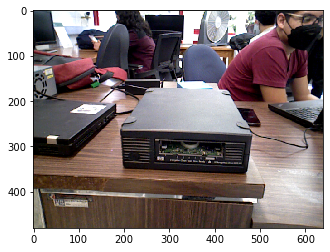

In [38]:
# Shape detection
import matplotlib.pyplot as plt
img = rgbd.get_image()

plt.imshow(img)
# img = np
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

ROI_number = 0
cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    print(len(approx))
    if len(approx)==5:
        print("Blue = pentagon")
        cv.drawContours(img,[cnt],0,255,-1)
    elif len(approx)==3:
        print("Green = triangle")
        cv.drawContours(img,[cnt],0,(0,255,0),-1)
    elif len(approx)==4:
        print("Red = square")
        cv.drawContours(img,[cnt],0,(0,0,255),-1)
    elif len(approx) == 6:
        print("Cyan = Hexa")
        cv.drawContours(img,[cnt],0,(255,255,0),-1)
    elif len(approx) == 8:
        print("White = Octa")
        cv.drawContours(img,[cnt],0,(255,255,255),-1)
    elif len(approx) > 12:
        print("Yellow = circle")
        cv.drawContours(img,[cnt],0,(0,255,255),-1)

cv2.imshow('image', img)
cv2.imshow('Binary',thresh)

In [4]:
rgbd.color_segmentator(color='blue')

[[0.0, 0.0]]

[ WARN] [1665596638.101836859, 187.116000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 187.188000 according to authority /pose_integrator
[ WARN] [1665596638.108287025, 187.116000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 187.188000 according to authority unknown_publisher
[ WARN] [1665596644.558820779, 188.127000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 188.148000 according to authority unknown_publisher
[ WARN] [1665596644.558903988, 188.127000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 188.148000 according to authority /pose_integrator


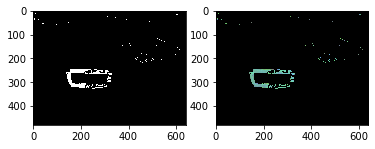

[[238.70561146170903, 267.14668258570697]]

In [10]:
# arm.set_named_target('go')
# arm.go()
# tiny_move_base(x=0.5,std_time=0.3)
hcp= [0,-0.5]
head.set_joint_value_target(hcp)
head.go()
color_segmentator(cam = 'head', color = 'blue',plot=True)
goalPos = [238.7, 267.1]

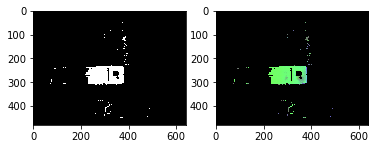

[[301.9245657997062, 268.31642616434806]]

In [11]:
gripper.open()

In [15]:
publish_point_tf(1,-2,2,'Object', ref='map')
# grasp_base.tiny_move(velT=0.5)


In [196]:
place_height=arm.get_current_joint_values()
print(place_height)
altura_optima = 0.1199


[0.11996212191564032, -0.004904528018885301, 0.011163654656305866, -1.5699986302849658, 1.586213108223816, 0.0]


In [23]:
traf = tfbuff.lookup_transform('arm_flex_link', 'Point Object', rospy.Time(0))
trans, rot = tf2_obj_2_arr(traf)
# print(trans,rot)
phi = np.arctan2(trans[1],trans[0])
base_point = np.array((trans[0], trans[1]))
distXY = np.linalg.norm(base_point)
print(phi, distXY)
succ = False
THRESHOLD = 0.02
while not succ:
    traf = tfbuff.lookup_transform('arm_flex_link', 'Point Object', rospy.Time(0))
    trans, rot = tf2_obj_2_arr(traf)
    # print(trans,rot)
    phi = np.arctan2(trans[1],trans[0])
    print(phi)
    if abs(phi)< THRESHOLD:
        succ =True
    else:
        grasp_base.tiny_move(velT = 0.5*phi)

-0.6290689722429843 1.8430254781511024
-0.6290689722429843
-0.5458996357232055
-0.3550002316838438
-0.2112649509194531
-0.11790797476636061
-0.06387548263366954
-0.034876784958602004
-0.01646697987846782


In [21]:
traf = tfbuff.lookup_transform('base_link', 'Point Object', rospy.Time(0))
trans, rot = tf2_obj_2_arr(traf)
# print(trans,rot)
phi = np.arctan2(trans[1],trans[0])
dist = np.sqrt(np.square(trans[0])+np.square(trans[1]))
print(phi, dist)

-1.4962030488427642 2.232888247295115


[ WARN] [1665717270.994381732, 2884.217000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2884.247000 according to authority /pose_integrator
[ WARN] [1665717270.995241433, 2884.217000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2884.247000 according to authority unknown_publisher
[ WARN] [1665717281.936966114, 2885.887000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2885.887000 according to authority /pose_integrator
[ WARN] [1665717281.939711160, 2885.887000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2885.887000 according to authority unknown_publisher


In [5]:
# grasp_base.tiny_move(velT=0.5)
acp= arm.get_current_joint_values()
acp[1] =-0.5
arm.set_joint_value_target(acp)
# arm.set_named_target('neutral')
arm.go()

[ WARN] [1665882665.859643946, 2312.079000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2312.129000 according to authority /pose_integrator
[ WARN] [1665882665.861215799, 2312.079000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2312.129000 according to authority unknown_publisher


True

[ WARN] [1665882691.422585818, 2314.481000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2314.573000 according to authority /pose_integrator
[ WARN] [1665882691.427626157, 2314.481000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2314.573000 according to authority unknown_publisher
[ WARN] [1665882701.060421785, 2315.472000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2315.529000 according to authority /pose_integrator
[ WARN] [1665882701.063515133, 2315.472000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2315.529000 according to authority unknown_publisher
[ WARN] [1665882709.393587006, 2316.612000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2316.642000 according to authority unknown_publisher
[ WARN] [1665882709.395958520, 2316.612000000]: TF_REPEATED_DATA ignoring data with redundant timestam

In [11]:
hcp= [0,0.0]
head.set_joint_value_target(hcp)
head.go()

False

In [13]:
# Calculo de la lambda necesaria para el efector final a partir del arm_roll_link
arm_link = 'arm_flex_link'
# arm_link = 'arm_roll_link'
traf_arl = tfbuff.lookup_transform("base_link",arm_link, rospy.Time(0)) #arm_roll_link
traf_point = tfbuff.lookup_transform("base_link","Point Object", rospy.Time(0))
A, _ = tf2_obj_2_arr(traf_arl) #Vector de posicion ARL
B, _ = tf2_obj_2_arr(traf_point) #Vector de posicion de objeto
# print(trans1,trans2)
A=np.array(A)
B=np.array(B)
V = np.add(-1*A,B) #Vector de direccion AB
# V=V*(1/abs(V))
# print(V)
traf_wrist = tfbuff.lookup_transform(arm_link,"hand_palm_link", rospy.Time(0))
trans3, _ = tf2_obj_2_arr(traf_wrist)
distance=np.linalg.norm(trans3)

V2= [n**2 for n in V]
V2=np.sum(V2)

l1 = distance/np.sqrt(V2)
print(l1)

# print(vector_dir)
posicion = np.add(A,V*1*l1)

print(posicion)
publish_point_tf(posicion[0],posicion[1],posicion[2], 'posicion',ref='base_link')


0.35678527967003004
[ 0.35597752 -0.18270493  0.21869283]


[ WARN] [1665795105.836013329, 3886.441000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3886.452000 according to authority /pose_integrator
[ WARN] [1665795105.837802203, 3886.441000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3886.452000 according to authority unknown_publisher


In [8]:
def point_at(target="Point Object",alpha =0.0):
#     arm.set_named_target('neutral')
#     arm.go()
    arm_f = 'arm_flex_link'
    arm_r= 'arm_roll_link'
    afl = tfbuff.lookup_transform(arm_f,"Point Object", rospy.Time(0)) #arm_roll_link
    arl = tfbuff.lookup_transform(arm_r,"Point Object", rospy.Time(0))
    al = tfbuff.lookup_transform(arm_f,arm_r, rospy.Time(0))
    afl, _ = tf2_obj_2_arr(afl) #Vector de posicion Arm Flex Link (codo)
    arl, _ = tf2_obj_2_arr(arl) #Vector de posicion Arm Roll Link (muñeca)
    al,_ = tf2_obj_2_arr(al) #Medida del brazo
    
    FR=al[2]
    RO= np.sqrt(arl[0]**2+arl[2]**2)
##geometria con 1 angulo
    z = afl[2]
    p = afl[0]
    xi = np.arctan2(p,z)
#     print(xi)
    beta = np.arcsin((-FR*np.sin(alpha+xi))/RO)+alpha+xi
    return alpha,beta   

In [16]:
point_pose=arm.get_current_joint_values()
# point_pose[1]=-alpha
# point_pose[3]=-np.pi+beta
# arm.set_joint_value_target(point_pose)
# arm.set_named_target('neutral')
arm.set_named_target('neutral')
arm.go()
a = 0.2
while(a < 2.61):
    alpha,beta =point_at(alpha=a)
    print(alpha,beta)
    point_pose[1]=-alpha
    point_pose[3]=-beta
    try:
        arm.set_joint_value_target(point_pose)
        succ=arm.go()
        if(succ):
            a=5
    except:
        a+=0.05
        

0.2 0.9471702345397318


In [16]:
arm.set_named_target('neutral')
arm.go()

# arm.set_pose_reference_frame('base_link')
# arm.get_pose_reference_frame()

[ WARN] [1665883978.213555881, 2492.070000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2492.109000 according to authority /pose_integrator
[ WARN] [1665883978.216365871, 2492.070000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2492.109000 according to authority unknown_publisher
[ WARN] [1665883984.728594361, 2493.055000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2493.097000 according to authority /pose_integrator
[ WARN] [1665883984.729684673, 2493.055000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2493.097000 according to authority unknown_publisher
[ WARN] [1665883999.659490285, 2495.356000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2495.416000 according to authority /pose_integrator
[ WARN] [1665883999.659855039, 2495.356000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

True

In [19]:
# traf = tfbuff.lookup_transform("head_rgbd_sensor_gazebo_frame","base_link", rospy.Time(0))
# print(traf)
class GAZE():
    def __init__(self):
        self._x = 0
        self._y = 0
        self._z = 0
        self._reference = 'map'
        self._cam = 'head_rgbd_sensor_gazebo_frame'
        self._base = 'base_link'
        self._hand = 'hand_palm_link'
    def _gaze_point(self):
    ###Moves head to make center point of rgbd image to coordinates w.r.t.map
        traf1 = tfbuff.lookup_transform(self._reference, self._cam, rospy.Time(0))
        rospy.sleep(0.5)
        traf2 = tfbuff.lookup_transform(self._reference, self._base, rospy.Time(0)) 
        trans,_ = tf2_obj_2_arr(traf1)
        _, rot = tf2_obj_2_arr(traf2)
        e = tf.transformations.euler_from_quaternion(rot)

        x_rob, y_rob, z_rob, th_rob = trans[0], trans[1], trans[2], e[2]

        D_x = x_rob - self._x
        D_y = y_rob - self._y
        D_z = z_rob - self._z
        D_th = np.arctan2(D_y,D_x)
        pan_correct = (- th_rob + D_th + np.pi) % (2*np.pi)
        if(pan_correct > np.pi):
            pan_correct -= 2*np.pi
        if(pan_correct < -np.pi):
            pan_correct += 2*np.pi

        if ((pan_correct) > .5 * np.pi):
            print ('Exorcist alert')
            pan_correct=.5*np.pi
        head_pose = [0,0]
        head_pose[0] = pan_correct
        tilt_correct = np.arctan2(D_z,np.linalg.norm((D_x,D_y)))
        head_pose [1] = -tilt_correct
        return head_pose
    
    def absolute(self, x, y, z):
        self._x = x
        self._y = y
        self._z = z
        self._reference = 'map'
        return self._gaze_point()
    def relative(self, x, y, z):
        self._x = x
        self._y = y
        self._z = z
        self._reference = 'base_link'
        return self._gaze_point()
    def hand(self, x, y, z):
        self._x = x
        self._y = y
        self._z = z
        self._reference = 'base_link'

In [21]:
gaze = GAZE()
hcp = gaze.relative(2,1,0)
head.set_joint_value_target(hcp)
head.go()

True

In [38]:
arm.set_named_target('neutral')
arm.go()
# traf1 = tfbuff.lookup_transform('base_link','hand_palm_link', rospy.Time(0))
# _,rot = tf2_obj_2_arr(traf1)
# e = tf.transformations.euler_from_quaternion(rot)
# print(e)
# rot=[0,0,0]
# rot[0] = e[0] + 3.14
# rot[1] = e[1] + 1.57
# rot[2] = e[2]
print(e)
# ori = tf.transformations.quaternion_from_euler(rot[0],rot[1], rot[2])
# arm.set_rpy_target([3.14,0,0])
# arm.go()

[ WARN] [1665772537.230576884, 2743.043000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.090000 according to authority unknown_publisher
[ WARN] [1665772537.233703701, 2743.043000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.090000 according to authority /pose_integrator
[ WARN] [1665772538.172287281, 2743.256000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.294000 according to authority /pose_integrator
[ WARN] [1665772538.172902152, 2743.256000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2743.294000 according to authority unknown_publisher
[ WARN] [1665772550.443827223, 2745.492000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2745.550000 according to authority unknown_publisher
[ WARN] [1665772550.456216027, 2745.492000000]: TF_REPEATED_DATA ignoring data with redundant timestam

NameError: name 'e' is not defined

[ WARN] [1665772567.499296082, 2748.552000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2748.552000 according to authority unknown_publisher
[ WARN] [1665772567.518603920, 2748.559000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2748.552000 according to authority /pose_integrator
[ WARN] [1665772582.563667281, 2751.006000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.034000 according to authority unknown_publisher
[ WARN] [1665772582.565756860, 2751.034000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.034000 according to authority /pose_integrator
[ WARN] [1665772584.309398714, 2751.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2751.367000 according to authority /pose_integrator
[ WARN] [1665772584.314123028, 2751.295000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [22]:
grasp_base.tiny_move(velT=0.5)

In [34]:
succ = False
THRESHOLD = 0.05
phi = np.arctan(trans[1]/trans[0])
while not succ:
    traf = tfbuff.lookup_transform("arm_flex_link","cassette", rospy.Time(0))
    # print(traf)
    trans, rot = tf2_obj_2_arr(traf)
    rot = tf.transformations.euler_from_quaternion(rot)
    alpha = rot[2]
    xi = alpha - phi
    grasp_base.tiny_move(velT=xi)
    print(xi)
    if abs(xi) < THRESHOLD:
        succ = True

0.8042043844640404


[ WARN] [1665623172.079860945, 430.524000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 430.545000 according to authority unknown_publisher
[ WARN] [1665623172.107544968, 430.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 430.545000 according to authority /pose_integrator


0.9627343380237757


[ WARN] [1665623178.398525695, 431.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.346000 according to authority /pose_integrator
[ WARN] [1665623178.401029254, 431.286000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.346000 according to authority unknown_publisher


1.227817450702567


[ WARN] [1665623181.641059997, 431.661000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.697000 according to authority unknown_publisher
[ WARN] [1665623181.641936006, 431.661000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 431.697000 according to authority /pose_integrator


1.474250966833053


[ WARN] [1665623186.121919611, 432.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 432.429000 according to authority unknown_publisher
[ WARN] [1665623186.134344189, 432.384000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 432.429000 according to authority /pose_integrator


1.7304860238569821
1.9436754175419153


[ WARN] [1665623195.792203083, 433.569000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 433.590000 according to authority unknown_publisher
[ WARN] [1665623195.794491022, 433.569000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 433.590000 according to authority /pose_integrator


2.1881240948556053
2.419387873087577


[ WARN] [1665623200.528027022, 434.259000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 434.304000 according to authority /pose_integrator
[ WARN] [1665623200.529587045, 434.259000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 434.304000 according to authority unknown_publisher


2.6639739419958235
2.934356938426432
3.1574973029198388


[ WARN] [1665623212.893324530, 435.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 436.023000 according to authority unknown_publisher
[ WARN] [1665623212.895272347, 435.981000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 436.023000 according to authority /pose_integrator


3.408525729593331
3.6601616117578124
3.8935089946995727
4.134903790481864
4.41233921939955


[ WARN] [1665623234.706972788, 438.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 438.411000 according to authority unknown_publisher
[ WARN] [1665623234.709088697, 438.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 438.411000 according to authority /pose_integrator


4.664969414303059
-1.3540786659722648


[ WARN] [1665623245.578816394, 439.650000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.668000 according to authority unknown_publisher
[ WARN] [1665623245.579854765, 439.650000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.668000 according to authority /pose_integrator


-1.5624566796020911


[ WARN] [1665623246.886324475, 439.773000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.836000 according to authority /pose_integrator
[ WARN] [1665623246.888148309, 439.773000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 439.836000 according to authority unknown_publisher
[ WARN] [1665623248.604699516, 440.025000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.025000 according to authority unknown_publisher
[ WARN] [1665623248.626293776, 440.025000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.025000 according to authority /pose_integrator


4.487474235895136
4.667659309994933


[ WARN] [1665623255.312984239, 440.703000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.787000 according to authority unknown_publisher
[ WARN] [1665623255.331032218, 440.787000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 440.787000 according to authority /pose_integrator
[ WARN] [1665623258.029371676, 441.060000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.096000 according to authority unknown_publisher
[ WARN] [1665623258.039671915, 441.060000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.096000 according to authority /pose_integrator


-1.3638119986572717


[ WARN] [1665623264.167902253, 441.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.756000 according to authority /pose_integrator
[ WARN] [1665623264.176762968, 441.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.756000 according to authority unknown_publisher


-1.4151915529706867


[ WARN] [1665623265.497318535, 441.873000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.903000 according to authority unknown_publisher
[ WARN] [1665623265.506412748, 441.873000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 441.903000 according to authority /pose_integrator
[ WARN] [1665623267.878054307, 442.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.140000 according to authority /pose_integrator
[ WARN] [1665623267.880019822, 442.104000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.140000 according to authority unknown_publisher


4.615697600946868


[ WARN] [1665623270.285622313, 442.383000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.422000 according to authority /pose_integrator
[ WARN] [1665623270.292976313, 442.383000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.422000 according to authority unknown_publisher
[ WARN] [1665623271.999579018, 442.599000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.626000 according to authority unknown_publisher
[ WARN] [1665623272.001248232, 442.599000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 442.626000 according to authority /pose_integrator


-1.5802119505662389
4.6589315749711115
-1.4430394984445338


[ WARN] [1665623283.838331838, 444.258000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.303000 according to authority /pose_integrator
[ WARN] [1665623283.840466262, 444.258000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.303000 according to authority unknown_publisher
[ WARN] [1665623285.206781637, 444.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.414000 according to authority unknown_publisher
[ WARN] [1665623285.215603913, 444.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 444.414000 according to authority /pose_integrator


-1.5959959081960315
4.402760262146424


[ WARN] [1665623290.656490580, 445.008000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 445.035000 according to authority /pose_integrator
[ WARN] [1665623290.659464316, 445.008000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 445.035000 according to authority unknown_publisher


KeyboardInterrupt: 

In [36]:
def rotar_base(theta = 0):
    traf = tfbuff.lookup_transform('base_link', 'map', rospy.Time(0))
    _, rot =tf2_obj_2_arr(traf)
    e =tf.transformations.euler_from_quaternion(rot)
    goal_theta = (e[2] + theta) % 2*np.pi
    print(goal_theta)
    succ = False
    THRESHOLD = 0.02
    while not succ:
        traf = tfbuff.lookup_transform('base_link', 'map', rospy.Time(0))
        _, rot =tf2_obj_2_arr(traf)
        e =tf.transformations.euler_from_quaternion(rot)
        curr_theta = e[2]
        err = (goal_theta - curr_theta) % 2*np.pi
        print(err)
        if abs(err)< THRESHOLD:
            succ = True
        else:
            grasp_base.tiny_move(velT = -0.5*err)
    

In [38]:
rotar_base(-1)

0.006814096139620673
3.15618567182326
2.434967778242641
1.739648494176337


[ WARN] [1665686426.180797506, 708.954000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 708.954000 according to authority unknown_publisher
[ WARN] [1665686426.210456096, 708.954000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 708.954000 according to authority /pose_integrator
[ WARN] [1665686428.192300923, 709.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 709.191000 according to authority unknown_publisher
[ WARN] [1665686428.193574911, 709.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 709.191000 according to authority /pose_integrator


0.9777885016442645


[ WARN] [1665686428.995814497, 709.227000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 709.332000 according to authority unknown_publisher
[ WARN] [1665686428.997963864, 709.227000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 709.332000 according to authority /pose_integrator


0.163530044684405
6.251635789069001
5.583146615886581
4.770902478145802
4.008180411953548


[ WARN] [1665686445.883236028, 711.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.888000 according to authority unknown_publisher
[ WARN] [1665686445.898051554, 711.888000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 711.888000 according to authority /pose_integrator


3.4361921738583128


[ WARN] [1665686447.859311152, 712.317000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 712.338000 according to authority unknown_publisher
[ WARN] [1665686447.863078712, 712.317000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 712.338000 according to authority /pose_integrator


3.325397069471233


[ WARN] [1665686453.037350288, 713.100000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 713.184000 according to authority unknown_publisher
[ WARN] [1665686453.039701383, 713.100000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 713.184000 according to authority /pose_integrator


2.569961072764837


[ WARN] [1665686456.518589707, 713.670000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 713.688000 according to authority unknown_publisher
[ WARN] [1665686456.521711522, 713.670000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 713.688000 according to authority /pose_integrator


1.8765012091359612
1.0794877546522166


[ WARN] [1665686462.601054989, 714.609000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 714.657000 according to authority unknown_publisher
[ WARN] [1665686462.611322195, 714.609000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 714.657000 according to authority /pose_integrator


0.2802333674339143
6.119099521497682


[ WARN] [1665686471.438894128, 715.779000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 715.821000 according to authority unknown_publisher
[ WARN] [1665686471.441686799, 715.779000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 715.821000 according to authority /pose_integrator


5.454792442750909


[ WARN] [1665686473.224347121, 715.974000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 716.055000 according to authority unknown_publisher
[ WARN] [1665686473.225688536, 715.974000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 716.055000 according to authority /pose_integrator


4.700370109887102
3.9343378315035635
3.2005855643698737


[ WARN] [1665686486.448201678, 717.630000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 717.687000 according to authority unknown_publisher
[ WARN] [1665686486.459327605, 717.630000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 717.687000 according to authority /pose_integrator
[ WARN] [1665686487.647704500, 717.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 717.780000 according to authority unknown_publisher
[ WARN] [1665686487.653451039, 717.780000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 717.780000 according to authority /pose_integrator


2.3573725858182355


KeyboardInterrupt: 

In [13]:
publish_point_tf(1,0,0,'Brazo1',ref='head_rgbd_sensor_gazebo_frame')
traf = tfbuff.lookup_transform('map','Point Brazo1', rospy.Time(0))
trans,_ = tf2_obj_2_arr(traf)
publish_point_tf(trans[0],trans[1],trans[2],'Brazo2',ref='map')


In [17]:
gripper.close()

In [24]:
traf = tfbuff.lookup_transform('base_link','ar_marker/201',rospy.Time(0))
tf2_obj_2_arr(traf)

[[0.6874551323475802, -0.07794949487462331, 0.6920933666831193],
 [0.38622610890625253,
  -0.9132626640126938,
  0.11953214690258941,
  -0.04992759934576225]]

shutdown request: [/Pruebas_de_placeo_v2] Reason: new node registered with same name
